# Diabetes Classification

## About dataset
- The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that collects data from U.S. residents on their health-related risk behaviors, chronic health conditions, and use of preventive services
- The dataset has been established in 1984 with 15 states, it now collects data from all 50 states, D.C., and 3 U.S. territories
- Over 400,000 adult interviews are completed each year, making it the largest continuous health survey system in the world
- Factors assessed include tobacco use, healthcare coverage, HIV/AIDS knowledge/prevention, physical activity, and fruit/vegetable consumption
- A record in the data corresponds to a single respondent (each from a single household)
- The description of columns can be found in the linked PDF file

Exploration showed the imbalance of target label. No was the dominant category with over 80% and Yes category populated around 15% of the dataset. The others are ignored and dropped.

#### Features description
| Feature               | Description                                                                  |
|-----------------------|------------------------------------------------------------------------------|
| diabetes              | Subject was told they have diabetes                                          |
| high_blood_pressure   | Subject has high blood pressure                                              |
| high_cholesterol      | Subject has high cholesterol                                                 |
| cholesterol_check     | Subject had cholesterol check within the last five years                     |
| bmi                   | BMI of the subject                                                           |
| smoked_100_cigarettes | Subject has smoked at least 100 cigarettes during their life                 |
| stroke                | Subject experienced stroke during their life                                 |
| coronary_disease      | Subject has/had coronary heart disease or myocardial infarction              |
| exercise              | Subject does regular exercise or physical activity                           |
| consumes_fruit        | Subject consumes fruits at least once a day                                  |
| consumes_vegetables   | Subject consumes vegetables at least once a day                              |
| heavy_alcohol_drinker | Heavy drinkers are defined as adult men having more than 14 drinks per week |
| insurance             | Subject has some kind of health plan (insurance, prepaid plans, ...)         |
| no_doctor_money       | Subject was unable to visit doctor in the past 12 months because of cost     |
| health                | How good is the health of the subject (self rated)                           |
| mental_health         | Number of days in the past month when subject's mental health was not good   |
| physical_health       | Number of days in the past month when subject's physical health was not good |
| climb_difficulty      | Subject has difficulties climbing stairs                                     |
| sex                   | Sex of the subject                                                           |
| age_category          | Age category of the subject                                                  |
| educatation_level     | Highest level of education achieved by the subject                           |
| income                | Income of subject's household                                                |;

Load the dataset. All 5 parts are concatenated

In [79]:
from core import load_dataset

dataset = load_dataset("data")

Do basic preprocessing on columns and categorical values in order to make the dataset more humanly readable.

In [80]:
from core import process_columns, remove_unusable_diabetes_categories

process_columns(dataset)

# 'Unnamed: 0' is a duplicate column of ID
dataset.drop("Unnamed: 0", axis="columns", inplace=True)

dataset.drop_duplicates(inplace=True)

    # ID is no longer needed after dropping duplicates
dataset.drop("ID", axis="columns", inplace=True)

# Remove rows where target label is missing
dataset = dataset[~dataset["diabetes"].isna()]

# Remove pre diabetes and diabetes in pregnancy categories
dataset_without_extended_diabetes_categories = remove_unusable_diabetes_categories(dataset)

Let's create a baseline model to have something to compare our more advanced models to.

In [81]:


from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

dataset = dataset_without_extended_diabetes_categories
X, y = dataset.drop("diabetes", axis="columns"), dataset["diabetes"]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)

baseline = DummyClassifier(strategy="uniform", random_state=0)
baseline.fit(train_X, train_y)
print(classification_report(test_y, baseline.predict(test_X), zero_division=0))


              precision    recall  f1-score   support

 Diabetes.NO       0.87      0.50      0.63     93156
Diabetes.YES       0.13      0.50      0.21     14184

    accuracy                           0.50    107340
   macro avg       0.50      0.50      0.42    107340
weighted avg       0.77      0.50      0.58    107340



Now we create the random forest model. The Scikit learn implementation of RF model requires that we first convert the data into numerical format.

In [91]:
import matplotlib.pyplot as plt
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Assuming dataset_with_extended_diabetes_categories is a pandas DataFrame
dataset = dataset_without_extended_diabetes_categories

# Splitting dataset into features and target
X = dataset.drop("diabetes", axis=1)
y = dataset["diabetes"]

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create preprocessing steps
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder())]
)

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, make_column_selector(dtype_include="category")),
    ]
)

# Create the pipeline
random_forest_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                random_state=42,
                class_weight="balanced_subsample",
                max_depth=12,
                max_features="sqrt",
                max_leaf_nodes=50,
                min_samples_leaf=50,
                n_estimators=120,
            ),
        ),
    ]
)
# 
# param_grid = {
#     "classifier__class_weight": ["balanced", "balanced_subsample", None],
#     "classifier__max_depth": [12, 15, 20, None],
#     "classifier__max_features": [None, "sqrt", "log2"],
#     "classifier__min_samples_leaf": [3, 3**2, 3**3, 3**4],
#     "classifier__max_leaf_nodes": [25, 50, 100, None],
#     "classifier__min_samples_leaf": [3, 3**2, 3**3, 3**4],
#     "classifier__n_estimators": [40, 80, 120, 160, 200],
# }
# 
# clf = GridSearchCV(random_forest_model, param_grid, scoring="recall_macro", n_jobs=-1)
# clf.fit(X_train[:3000], y_train[:3000])
# 
# print(clf.best_params_)
# print(classification_report(y_test, clf.predict(X_test)))

random_forest_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fff11da6ad0>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fff3394b750>)])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=12, max_leaf_nodes=50,
                                        min_samples_leaf=50, n_estimators=120,
                                        random_state=42))])

Let's see how our first model performs.

Recall:		0.8096023615210974
Precision:	0.29475913516247315
F1:		0.4321731473328081
Accuracy:	0.7146450531022918


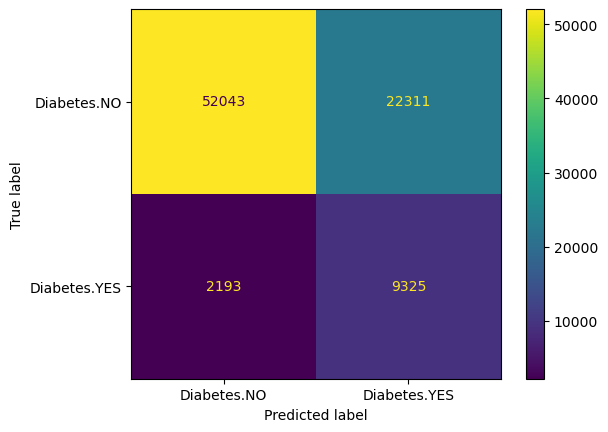

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score


rfm_pred = random_forest_model.predict(X_test)

print(f"Recall:\t\t{recall_score(y_test, rfm_pred, pos_label='Diabetes.YES')}")
print(
    f"Precision:\t{precision_score(y_test, rfm_pred, pos_label='Diabetes.YES')}"
)
print(f"F1:\t\t{f1_score(y_test, rfm_pred, pos_label='Diabetes.YES')}")
print(f"Accuracy:\t{accuracy_score(y_test, rfm_pred)}")

# Display confusion matrix
cm = confusion_matrix(y_test, rfm_pred)
ConfusionMatrixDisplay(cm, display_labels=random_forest_model.classes_).plot()
plt.show()

Now we split the dataset into training and testing.

In [85]:
from sklearn.model_selection import train_test_split

dataset = dataset_without_extended_diabetes_categories
diabetes_X, diabetes_y = dataset.drop(columns="diabetes"), dataset.diabetes

diabetes_train_X, diabetes_test_X, diabetes_train_y, diabetes_test_y = train_test_split(
    diabetes_X, diabetes_y, test_size=0.2, random_state=42
)

### And next a perceptron.

In [86]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Perceptron
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(diabetes_X, diabetes_y, test_size=0.2, random_state=42)

perceptron_column_transformer = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

perceptron_model = make_pipeline(
    perceptron_column_transformer,
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    Perceptron()
)

params_grid = {
    "perceptron__class_weight": [None, 'balanced'],
    "perceptron__penalty": [None, 'l2', 'l1', 'elasticnet'],
    "perceptron__alpha": [0.0001, 0.001, 0.01, 0.1],
    "perceptron__eta0": [0.1, 1, 10],
    "perceptron__shuffle": [True, False]
}

clf = GridSearchCV(perceptron_model, params_grid, cv=10, scoring="recall_macro", n_jobs=-1)
# clf.fit(X_train[:2000], y_train[:2000])

# print(clf.best_params_)
# print(classification_report(y_test, clf.predict(X_test), zero_division=0.0))

Based on grid search we choose to create this model.

Recall:		0.8378190658100365
Precision:	0.22570459595368964
F1:		0.35560960330182595
Accuracy:	0.5927310415502143


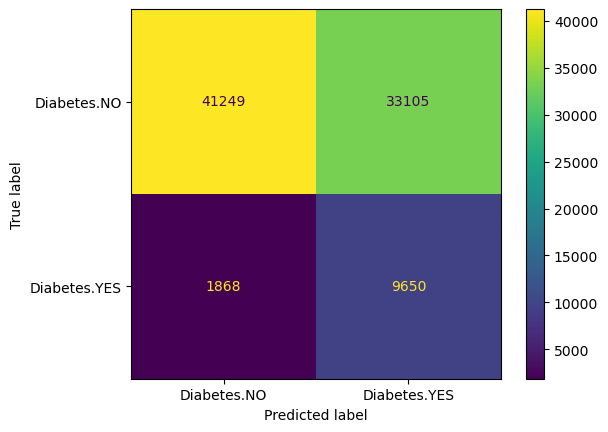

In [87]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

perceptron_final_model = make_pipeline(
    perceptron_column_transformer,
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    Perceptron(
        alpha=0.0001, class_weight="balanced", eta0=0.1, penalty="l1", shuffle=False
    ),
)

perceptron_final_model.fit(diabetes_train_X[:10000], diabetes_train_y[:10000])

svm_predicted = perceptron_final_model.predict(diabetes_test_X)


print(f"Recall:\t\t{recall_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Precision:\t{precision_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"F1:\t\t{f1_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Accuracy:\t{accuracy_score(diabetes_test_y, svm_predicted)}")

# Display confusion matrix
cm = confusion_matrix(diabetes_test_y, svm_predicted)
ConfusionMatrixDisplay(cm, display_labels=perceptron_final_model.classes_).plot()
plt.show()

### Now let's look at the SVM Model

In [88]:
# # SVM Model

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

svm_column_transformer = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include="category")),
    remainder="passthrough"
)


svm_pipeline = make_pipeline(
    svm_column_transformer,
    KNNImputer(n_neighbors=3),
    MinMaxScaler(feature_range=(0, 1)),
    SVC(kernel="poly", C=8, degree=5, class_weight="balanced")
)

In [89]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

params = [
    {
    # "knnimputer__n_neighbors": [1, 2, 3, 5],
    "svc__kernel": ["poly"],
    "svc__C": [0.5, 1, 2, 4, 8, 16],
    "svc__degree": [1, 2, 3, 4, 5, 6],
    },
    {
    # "knnimputer__n_neighbors": [1, 2, 3, 5],
    "svc__kernel": ["rbf"],
    "svc__C": [0.001, 0.05, 0.5, 1, 2, 4, 8, 16, 20],
    "svc__gamma": ["auto", 0.0001, .0002, 0.00025, 0.0003, 0.0005, 0.001, 0.01, 0.1, 1, 2, 4, 8]
    },
    {
    # "knnimputer__n_neighbors": [1, 2, 3, 5],
    "svc__kernel": ["linear"],
    }
]


recall_diabetes = make_scorer(recall_score, pos_label="Diabetes.YES")
grid_search = GridSearchCV(svm_pipeline, cv=3, param_grid=params, scoring=recall_diabetes, verbose=2, n_jobs=3)
# grid_search.fit(diabetes_train_X, diabetes_train_y)
# grid_search.best_score_
# grid_search.best_params # kernel='rbf'; C=0.05; gamma=0.1; n_neighbors=3

Recall:		0.7980552179197777
Precision:	0.2750366536010293
F1:		0.40908787467455887
Accuracy:	0.6907606670393144


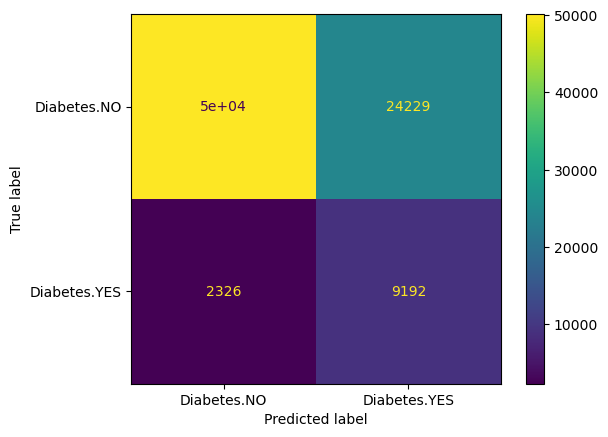

In [90]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
)

# Final SVM pipeline
svm_pipeline = make_pipeline(
    svm_column_transformer,
    KNNImputer(n_neighbors=3),
    MinMaxScaler(feature_range=(0, 1)),
    SVC(kernel="rbf", C=0.05, gamma=0.1, class_weight="balanced",)
)

svm_pipeline.fit(diabetes_train_X[:10000], diabetes_train_y[:10000])

svm_predicted = svm_pipeline.predict(diabetes_test_X)


print(f"Recall:\t\t{recall_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Precision:\t{precision_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"F1:\t\t{f1_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Accuracy:\t{accuracy_score(diabetes_test_y, svm_predicted)}")

# Display confusion matrix
cm = confusion_matrix(diabetes_test_y, svm_predicted)
ConfusionMatrixDisplay(cm, display_labels=svm_pipeline.classes_).plot()
plt.show()